In [1]:
from cv2 import resize
import numpy as np
import pandas as pd
import matplotlib
import os
from matplotlib import image, pyplot as plt

In [2]:
def get_image_data(h_types, window, h_type_image_count, dim, rand=0):
    np.random.seed(rand)
    data = []
    labels = []
    num_images_list = [h_type_image_count for _ in range(len(h_types))] if isinstance(h_type_image_count, int) else h_type_image_count
    assert(len(num_images_list) == len(h_types))
    
    for h_type, num_images in zip(h_types, num_images_list):
        print(f'Starting {h_type}.')
        file_dir = f'dcms/renders/{h_type}/{window}/'
        img_names = np.array(os.listdir(file_dir))
        np.random.shuffle(img_names)
        if (n := len(img_names)) < num_images:
            print(f'You asked for {num_images}, but can only find {n} for {h_type}. Returning {n} images.')
        else:
            img_names = img_names[:num_images]

        ACTUAL_NUM_IMAGES = len(img_names)

        pulled_data = np.zeros([ACTUAL_NUM_IMAGES, dim[0] * dim[1]])

        for i, img in enumerate(img_names):
            if (i % 1000) == 0:
                print(f'{h_type}: {i}/{pulled_data.shape[0]}')
            im = np.mean(matplotlib.image.imread(file_dir + img),axis=2)
            if ((s := im.shape) != (512,512)):
                print(f'{img} not of correct dimensions (512,512). It is instead {s}. Removing image.')
                ACTUAL_NUM_IMAGES -= 1
                continue
            pulled_data[i,:] = resize(im, dim).reshape(1, -1)
        
        data.append(pulled_data[:ACTUAL_NUM_IMAGES])
        labels.append(np.repeat(h_type, ACTUAL_NUM_IMAGES))
        print(f'Finished {h_type}.')
    
    return np.concatenate(data), np.concatenate(labels)

In [3]:
X, y = get_image_data(['epidural', 'normal', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural'], 'brain_window', 5000, (64,64))

Starting epidural.
You asked for 5000, but can only find 1694 for epidural. Returning 1694 images.
epidural: 0/1694
epidural: 1000/1694
Finished epidural.
Starting normal.
normal: 0/5000
normal: 1000/5000
ID_0144e4030.jpg not of correct dimensions (512,512). It is instead (464, 464). Removing image.
normal: 2000/5000
normal: 3000/5000
normal: 4000/5000
Finished normal.
Starting intraparenchymal.
intraparenchymal: 0/5000
intraparenchymal: 1000/5000
intraparenchymal: 2000/5000
intraparenchymal: 3000/5000
intraparenchymal: 4000/5000
Finished intraparenchymal.
Starting intraventricular.
intraventricular: 0/5000
intraventricular: 1000/5000
intraventricular: 2000/5000
intraventricular: 3000/5000
intraventricular: 4000/5000
Finished intraventricular.
Starting subarachnoid.
subarachnoid: 0/5000
subarachnoid: 1000/5000
subarachnoid: 2000/5000
subarachnoid: 3000/5000
subarachnoid: 4000/5000
Finished subarachnoid.
Starting subdural.
subdural: 0/5000
ID_a9ab8569f.jpg not of correct dimensions (512

In [4]:
print(X.shape)
print(y.shape)

(26676, 4096)
(26676,)


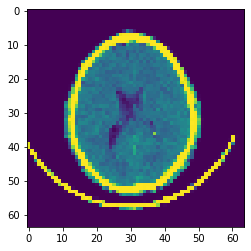

In [5]:
matplotlib.pyplot.imshow(X[2].reshape(64,64));

In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, MaxPooling2D, Conv2D

In [7]:
hem_type_dict = {'epidural':0,
                 'intraparenchymal':1,
                 'intraventricular':2,
                 'normal':3,
                 'subarachnoid':4,
                 'subdural':5}
y_numerical = np.array([hem_type_dict.get(i) for i in y])

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y_numerical, test_size=0.2, random_state=0)
X_train2, X_valid2, y_train2, y_valid2 = train_test_split(X, y_numerical, test_size=0.2, random_state=0)
X_train3, X_valid3, y_train3, y_valid3 = train_test_split(X, y_numerical, test_size=0.2, random_state=0)
X_train4, X_valid4, y_train4, y_valid4 = train_test_split(X, y_numerical, test_size=0.2, random_state=0)
print(y_train.shape, y_valid.shape)
print(X_train.shape, X_valid.shape)

(21340,) (5336,)
(21340, 4096) (5336, 4096)


<h3> NEURAL NETS! </h3>

In [9]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [10]:
NUM_LABELS = 6

# renormalize training data
X_train = X_train.astype('float32')
X_valid = X_valid.astype('float32')
X_train /= 255
X_valid /= 255


X_train = X_train.reshape(-1,64,64,1)
X_valid = X_valid.reshape(-1,64,64,1)

y_train = np_utils.to_categorical(y_train, NUM_LABELS)
y_valid = np_utils.to_categorical(y_valid, NUM_LABELS)

print(X_train.shape, X_valid.shape)

(21340, 64, 64, 1) (5336, 64, 64, 1)


In [11]:
# Creating our model
model = Sequential()

model.add(Conv2D(32, (7,7),
                 padding='valid',
                 input_shape=(64,64,1),
                 activation='sigmoid'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, (3,3),
                 activation='sigmoid'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dense(units=128, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(units=NUM_LABELS, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 58, 58, 32)        1600      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 29, 29, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 13, 13, 32)        0         
                                                                 
 flatten (Flatten)           (None, 5408)              0

In [12]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [13]:
epochs = 10

history = model.fit(X_train, 
                    y_train, 
                    epochs=epochs, 
                    batch_size=128,
                    verbose=1,
                    validation_data=(X_valid, y_valid))

Epoch 1/10


2022-04-26 18:21:52.472800: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


167/167 [==============================] - 17s 97ms/step - loss: 1.8445 - accuracy: 0.1893 - val_loss: 1.7460 - val_accuracy: 0.1867
Epoch 2/10
167/167 [==============================] - 16s 93ms/step - loss: 1.6944 - accuracy: 0.2525 - val_loss: 1.6585 - val_accuracy: 0.2813
Epoch 3/10
167/167 [==============================] - 15s 90ms/step - loss: 1.6598 - accuracy: 0.2823 - val_loss: 1.6308 - val_accuracy: 0.3109
Epoch 4/10
167/167 [==============================] - 15s 91ms/step - loss: 1.6405 - accuracy: 0.2948 - val_loss: 1.6075 - val_accuracy: 0.3203
Epoch 5/10
167/167 [==============================] - 15s 91ms/step - loss: 1.6284 - accuracy: 0.3013 - val_loss: 1.6140 - val_accuracy: 0.3027
Epoch 6/10
167/167 [==============================] - 16s 94ms/step - loss: 1.6193 - accuracy: 0.3074 - val_loss: 1.5980 - val_accuracy: 0.3171
Epoch 7/10
167/167 [==============================] - 16s 95ms/step - loss: 1.6085 - accuracy: 0.3132 - val_loss: 1.5941 - val_accuracy: 0.3216
Epo

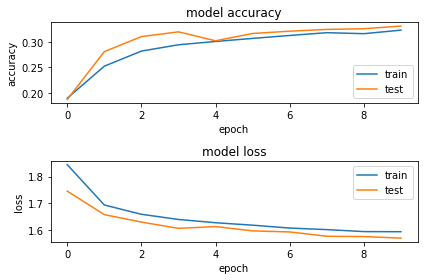

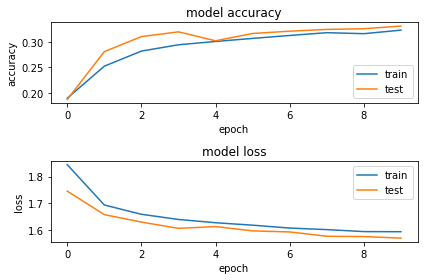

In [14]:
# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

fig

## Model 2

In [15]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [16]:
NUM_LABELS = 6

# renormalize training data
X_train2 = X_train2.astype('float32')
X_valid2 = X_valid2.astype('float32')
X_train2 /= 255
X_valid2 /= 255


X_train2 = X_train2.reshape(-1,64,64,1)
X_valid2 = X_valid2.reshape(-1,64,64,1)

y_train2 = np_utils.to_categorical(y_train2, NUM_LABELS)
y_valid2 = np_utils.to_categorical(y_valid2, NUM_LABELS)

print(X_train2.shape, X_valid2.shape)

(21340, 64, 64, 1) (5336, 64, 64, 1)


In [17]:
# Creating our model
model = Sequential()

model.add(Conv2D(32, (7,7),
                 padding='valid',
                 input_shape=(64,64,1),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, (3,3),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=NUM_LABELS, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 58, 58, 32)        1600      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 29, 29, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 13, 13, 32)        0         
                                                                 
 flatten (Flatten)           (None, 5408)              0

In [18]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [19]:
epochs = 10

history = model.fit(X_train2, 
                    y_train2, 
                    epochs=epochs, 
                    batch_size=128,
                    verbose=1,
                    validation_data=(X_valid2, y_valid2))

Epoch 1/10
167/167 [==============================] - 15s 88ms/step - loss: 1.6250 - accuracy: 0.3124 - val_loss: 1.5818 - val_accuracy: 0.3394
Epoch 2/10
167/167 [==============================] - 15s 90ms/step - loss: 1.5534 - accuracy: 0.3548 - val_loss: 1.5363 - val_accuracy: 0.3668
Epoch 3/10
167/167 [==============================] - 14s 86ms/step - loss: 1.5185 - accuracy: 0.3687 - val_loss: 1.4943 - val_accuracy: 0.3898
Epoch 4/10
167/167 [==============================] - 14s 85ms/step - loss: 1.4825 - accuracy: 0.3875 - val_loss: 1.4687 - val_accuracy: 0.3937
Epoch 5/10
167/167 [==============================] - 15s 88ms/step - loss: 1.4451 - accuracy: 0.4062 - val_loss: 1.4577 - val_accuracy: 0.4024
Epoch 6/10
167/167 [==============================] - 15s 88ms/step - loss: 1.4054 - accuracy: 0.4282 - val_loss: 1.4340 - val_accuracy: 0.4204
Epoch 7/10
167/167 [==============================] - 15s 88ms/step - loss: 1.3715 - accuracy: 0.4450 - val_loss: 1.4250 - val_accuracy:

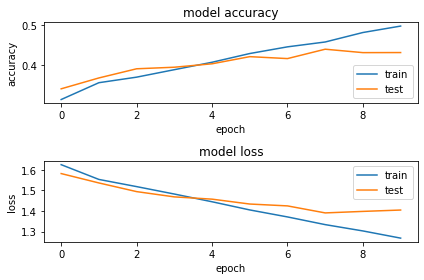

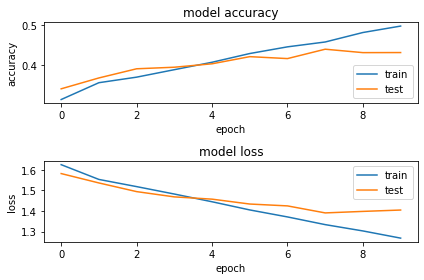

In [20]:
# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

fig

## Model 3

In [21]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [22]:
NUM_LABELS = 6

# renormalize training data
X_train3 = X_train3.astype('float32')
X_valid3 = X_valid3.astype('float32')
X_train3 /= 255
X_valid3 /= 255


X_train3 = X_train3.reshape(-1,64,64,1)
X_valid3 = X_valid3.reshape(-1,64,64,1)

y_train3 = np_utils.to_categorical(y_train3, NUM_LABELS)
y_valid3 = np_utils.to_categorical(y_valid3, NUM_LABELS)

print(X_train3.shape, X_valid3.shape)

(21340, 64, 64, 1) (5336, 64, 64, 1)


In [23]:
# Creating our model
model = Sequential()

model.add(Conv2D(32, (7,7),
                 padding='valid',
                 input_shape=(64,64,1),
                 activation='linear'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, (3,3),
                 activation='linear'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dense(units=128, activation='linear'))
model.add(Dropout(0.5))
model.add(Dense(units=NUM_LABELS, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 58, 58, 32)        1600      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 29, 29, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 13, 13, 32)        0         
                                                                 
 flatten (Flatten)           (None, 5408)              0

In [24]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [25]:
epochs = 10

history = model.fit(X_train3, 
                    y_train3, 
                    epochs=epochs, 
                    batch_size=128,
                    verbose=1,
                    validation_data=(X_valid3, y_valid3))

Epoch 1/10
167/167 [==============================] - 15s 86ms/step - loss: 1.6830 - accuracy: 0.3119 - val_loss: 1.6725 - val_accuracy: 0.3124
Epoch 2/10
167/167 [==============================] - 15s 89ms/step - loss: 1.5613 - accuracy: 0.3583 - val_loss: 1.5373 - val_accuracy: 0.3579
Epoch 3/10
167/167 [==============================] - 14s 86ms/step - loss: 1.5053 - accuracy: 0.3885 - val_loss: 1.5331 - val_accuracy: 0.3574
Epoch 4/10
167/167 [==============================] - 14s 86ms/step - loss: 1.4565 - accuracy: 0.4117 - val_loss: 1.5039 - val_accuracy: 0.3662
Epoch 5/10
167/167 [==============================] - 14s 85ms/step - loss: 1.4126 - accuracy: 0.4342 - val_loss: 1.5111 - val_accuracy: 0.3789
Epoch 6/10
167/167 [==============================] - 14s 83ms/step - loss: 1.3663 - accuracy: 0.4542 - val_loss: 1.5303 - val_accuracy: 0.3754
Epoch 7/10
167/167 [==============================] - 14s 85ms/step - loss: 1.3331 - accuracy: 0.4709 - val_loss: 1.5105 - val_accuracy:

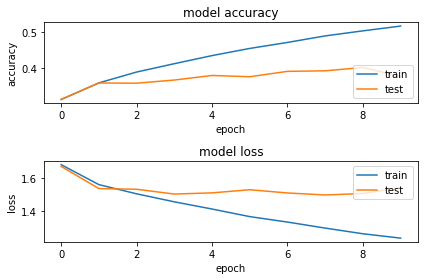

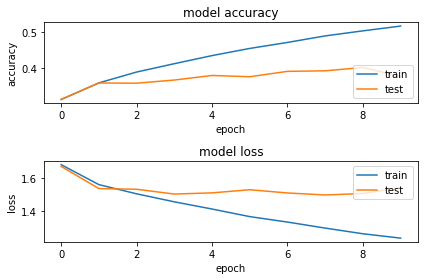

In [26]:
# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

fig

## Model 4

In [27]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [28]:
NUM_LABELS = 6

# renormalize training data
X_train4 = X_train4.astype('float32')
X_valid4 = X_valid4.astype('float32')
X_train4 /= 255
X_valid4 /= 255


X_train4 = X_train4.reshape(-1,64,64,1)
X_valid4 = X_valid4.reshape(-1,64,64,1)

y_train4 = np_utils.to_categorical(y_train4, NUM_LABELS)
y_valid4 = np_utils.to_categorical(y_valid4, NUM_LABELS)

print(X_train4.shape, X_valid4.shape)

(21340, 64, 64, 1) (5336, 64, 64, 1)


In [29]:
# Creating our model
model = Sequential()

model.add(Conv2D(32, (7,7),
                 padding='valid',
                 input_shape=(64,64,1),
                 activation='softmax'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, (3,3),
                 activation='softmax'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dense(units=128, activation='softmax'))
model.add(Dropout(0.5))
model.add(Dense(units=NUM_LABELS, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 58, 58, 32)        1600      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 29, 29, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 13, 13, 32)        0         
                                                                 
 flatten (Flatten)           (None, 5408)              0

In [30]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [31]:
epochs = 10

history = model.fit(X_train4, 
                    y_train4, 
                    epochs=epochs, 
                    batch_size=128,
                    verbose=1,
                    validation_data=(X_valid4, y_valid4))

Epoch 1/10
167/167 [==============================] - 17s 98ms/step - loss: 1.7618 - accuracy: 0.1828 - val_loss: 1.7484 - val_accuracy: 0.1910
Epoch 2/10
167/167 [==============================] - 16s 96ms/step - loss: 1.7405 - accuracy: 0.2081 - val_loss: 1.7184 - val_accuracy: 0.2519
Epoch 3/10
167/167 [==============================] - 16s 95ms/step - loss: 1.7171 - accuracy: 0.2476 - val_loss: 1.7015 - val_accuracy: 0.2785
Epoch 4/10
167/167 [==============================] - 15s 93ms/step - loss: 1.7048 - accuracy: 0.2651 - val_loss: 1.6875 - val_accuracy: 0.2832
Epoch 5/10
167/167 [==============================] - 15s 92ms/step - loss: 1.6945 - accuracy: 0.2730 - val_loss: 1.6763 - val_accuracy: 0.2864
Epoch 6/10
167/167 [==============================] - 15s 91ms/step - loss: 1.6847 - accuracy: 0.2759 - val_loss: 1.6675 - val_accuracy: 0.2969
Epoch 7/10
167/167 [==============================] - 15s 93ms/step - loss: 1.6772 - accuracy: 0.2817 - val_loss: 1.6576 - val_accuracy:

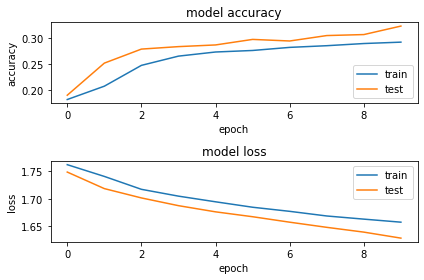

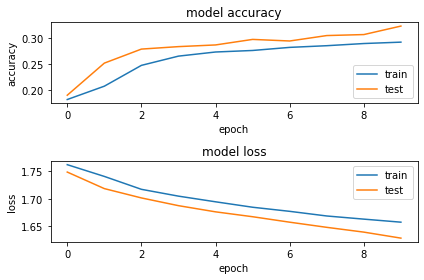

In [32]:
# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

fig